In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# 1. Generate Synthetic Data
np.random.seed(42)
n_rows = 5000

# Create Data
data = {
    'Customer_ID': np.random.randint(1000, 2000, n_rows),
    'Invoice_Date': pd.date_range(start='2023-01-01', end='2023-12-31', periods=n_rows),
    'Quantity': np.random.randint(1, 10, n_rows),
    'Unit_Price': np.random.uniform(10, 100, n_rows)
}
df = pd.DataFrame(data)

# Introduce some "Canceled Orders" (Negative Quantity) to test cleaning
df.loc[::50, 'Quantity'] = df.loc[::50, 'Quantity'] * -1

# Calculate Total Spend per row
df['Total_Price'] = df['Quantity'] * df['Unit_Price']

print("Data Generated. Shape:", df.shape)
df.head()

Data Generated. Shape: (5000, 5)


,Customer_ID,Invoice_Date,Quantity,Unit_Price,Total_Price
0,1102,2023-01-01 00:00:00.000000000,-8,71.939703,-575.517622
1,1435,2023-01-01 01:44:51.178235647,7,80.650615,564.554307
2,1860,2023-01-01 03:29:42.356471294,6,81.575906,489.455438
3,1270,2023-01-01 05:14:33.534706941,7,22.194507,155.361547
4,1106,2023-01-01 06:59:24.712942588,5,50.281296,251.406478


In [2]:
# 1. Remove Canceled Orders (Negative Quantity)
df_clean = df[df['Quantity'] > 0].copy()

# 2. Ensure Date Format
df_clean['Invoice_Date'] = pd.to_datetime(df_clean['Invoice_Date'])

print(f"Cleaned Data: {len(df_clean)} rows (dropped {len(df) - len(df_clean)} bad rows)")

Cleaned Data: 4900 rows (dropped 100 bad rows)


In [3]:
# Set "Reference Date" as the day after the last purchase in dataset
ref_date = df_clean['Invoice_Date'].max() + dt.timedelta(days=1)

# Group by Customer to get RFM
rfm = df_clean.groupby('Customer_ID').agg({
    'Invoice_Date': lambda x: (ref_date - x.max()).days, # Recency
    'Customer_ID': 'count',                              # Frequency (Count of orders)
    'Total_Price': 'sum'                                 # Monetary
}).rename(columns={
    'Invoice_Date': 'Recency',
    'Customer_ID': 'Frequency',
    'Total_Price': 'Monetary'
})

print(rfm.head())

             Recency  Frequency     Monetary
Customer_ID                                 
1000               5          9  2593.163045
1001             147          6  2387.931342
1002             152          4  1279.221259
1003             232          2   825.670579
1004             261          5   859.960425


In [4]:
# Labels: 4 is Best, 1 is Worst
r_labels = [4, 3, 2, 1] # Recency: Lower days is better (4)
f_labels = [1, 2, 3, 4] # Frequency: Higher count is better (4)
m_labels = [1, 2, 3, 4] # Monetary: Higher spend is better (4)

rfm['R_Score'] = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=f_labels)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], q=4, labels=m_labels)

# Combine into a single string (e.g., "444" is best)
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

print(rfm[['Recency', 'Frequency', 'Monetary', 'RFM_Segment']].head())

             Recency  Frequency     Monetary RFM_Segment
Customer_ID                                             
1000               5          9  2593.163045         444
1001             147          6  2387.931342         134
1002             152          4  1279.221259         123
1003             232          2   825.670579         112
1004             261          5   859.960425         122


/tmp/ipython-input-542010698.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Customer_Segment', data=rfm, order=rfm['Customer_Segment'].value_counts().index, palette='viridis')


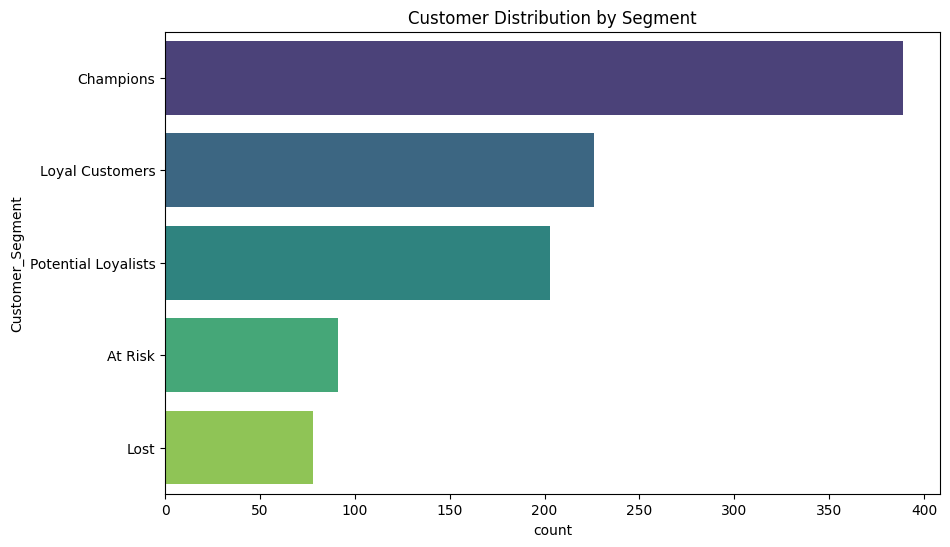

In [5]:
# Define Segments based on RFM Score
def segment_customer(df):
    if df['RFM_Score'] >= 9:
        return 'Champions'
    elif (df['RFM_Score'] >= 7) and (df['RFM_Score'] < 9):
        return 'Loyal Customers'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 7):
        return 'Potential Loyalists'
    elif (df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5):
        return 'At Risk'
    else:
        return 'Lost'

rfm['Customer_Segment'] = rfm.apply(segment_customer, axis=1)

# Visualization
plt.figure(figsize=(10, 6))
sns.countplot(y='Customer_Segment', data=rfm, order=rfm['Customer_Segment'].value_counts().index, palette='viridis')
plt.title('Customer Distribution by Segment')
plt.show()

In [6]:
rfm.to_csv('rfm_segments.csv')
print("RFM Analysis Saved!")

RFM Analysis Saved!
